In [1]:
from importers import SpikeImporter

# load the animal file
importer = SpikeImporter(filepath = "../data/11_10_27U2a_2030s_2100s_10000Hz.csv")

# try retrieving the APs and eletrical stimuli
# print(importer.getActionPotentials(channel_name = "801 nw-1"))
# print(importer.getElectricalStimuli(channel_name = "32 DigMark"))
print("Data loaded.")

Data loaded.


In [2]:
import signal_artifacts
# reload the signal_artifacts classes
# hacky workaround atm
import importlib
importlib.reload(signal_artifacts)
# only now, import the individual classes
from signal_artifacts import ActionPotential
from signal_artifacts import ElectricalStimulus

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005
# state explicitly the name of the time column
time_column = "Time"


# go through the eletrical stimuli dataframe and construct objects from this
el_stimuli_df = importer.getElectricalStimuli(channel_name = "32 DigMark")
el_stimuli = []
for index, row in el_stimuli_df.iterrows():
    es = ElectricalStimulus(input_data = row)
    el_stimuli.append(es)
print("List of eletrical stimuli created.")


# go through the dataframe and construct the APs
actpots_df = importer.getActionPotentials(channel_name = "801 nw-1")
actpots = []
index = 0
while index < len(actpots_df.index) - 1:
    # assume that the first index is always the onset of an AP
    onset = index
    
    len_df = len(actpots_df.index)
    # increase the DF(!) index as long as the time distance to the next row is small enough
    while (abs(actpots_df.iloc[index + 1][time_column] - actpots_df.iloc[index][time_column]) < max_gap_time):
        index = index + 1
        # break out of the loop if we reached the end
        if (index == len_df - 1):
            break
        
    # then, this is the last index
    offset = index
        
    # create AP object from the shortened dataframe
    # range does not include the last position, therefore + 1 !
    # also, pass the electrical stimuli so that the class can get the closest one
    # print(str(onset) + " to " + str(offset))
    ap = ActionPotential(input_df = actpots_df.iloc[range(onset, offset + 1)], el_stimuli = el_stimuli)
    actpots.append(ap)
    
    # "jump" to the next AP
    index = index + 1
print("List of APs created.")

List of eletrical stimuli created.
List of APs created.


Plotting cluster: -1
Plotting cluster: 0


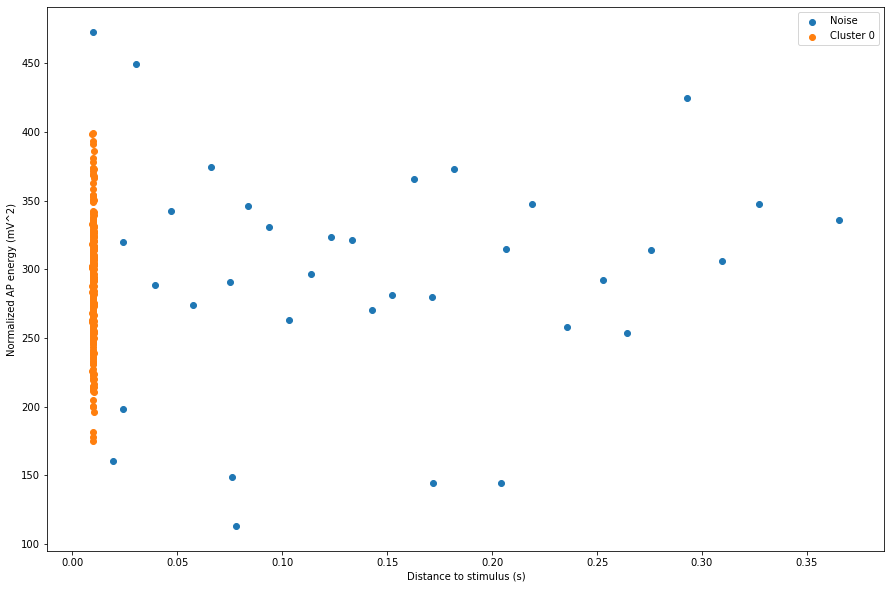

<Figure size 432x288 with 0 Axes>

In [29]:
import clustering
# reload the clustering classes
# hacky workaround atm
import importlib
importlib.reload(clustering)

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

# build feature vectors from the features provided by AP class
features = np.array([[ap.getDistanceToPreviousElectricalStimulus(), ap.getNormalizedEnergy()] for ap in actpots])
labels = DBSCAN(eps = 0.01, min_samples = 3, metric = clustering.actionPotDistance).fit_predict(features)

# initialize figure
plt.figure(figsize = (15, 10))

# iterate over all the clusters and plot them
cluster_index = -1
while cluster_index <= max(labels):
    # get a mask for all samples belonging to the cluster and retrieve those feature vectors
    indices = (labels == cluster_index)
    cluster_features = features[indices]
    # plot the cluster with the appropriate label
    print("Plotting cluster: " + str(cluster_index))
    plt.scatter(x = cluster_features[: , 0], y = cluster_features[:, 1], label = "Cluster " + str(cluster_index) if cluster_index > -1 else "Noise")
    # go to the next cluster
    cluster_index = cluster_index + 1

plt.xlabel("Distance to stimulus (s)")
plt.ylabel("Normalized AP energy (mV^2)")
plt.legend()
plt.savefig("../results/DBSCAN_clustering_0.png", dpi = 400)
plt.show()